In [83]:
import cdms2 as cdms
import MV2 as MV
import cdtime,cdutil,genutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import glob
import scipy.stats as stats
# Local solution
# If running remotely, uncomment the following code:
# %%bash
# git clone https://github.com/katemarvel/CMIP5_tools
# import CMIP5_tools as cmip5
import sys,os
#sys.path.append("/Users/kmarvel/Google Drive/python-utils")
sys.path.append("../python-utils")
import CMIP5_tools as cmip5
import DA_tools
import Plotting

from eofs.cdms import Eof
from eofs.multivariate.cdms import MultivariateEof
%matplotlib inline

import requests
import pandas as pd
import importlib

### Set classic Netcdf (ver 3)
cdms.setNetcdfShuffleFlag(0)
cdms.setNetcdfDeflateFlag(0)
cdms.setNetcdfDeflateLevelFlag(0)

#external_drive='/Volumes/CMIP6/'
external_drive="/home/kdm2144/"

In [84]:
#Region locations
NCA4regions={}
#Northwest (NW): (125°W–111°W, 42°N–49°N)
NCA4regions["NW"]={}
NCA4regions["NW"]["longitude"]=(-125,-111)
NCA4regions["NW"]["latitude"]=(42,49)

#Southwest (SW): (124°W–102°W, 31°N–42°N)
NCA4regions["SW"]={}
NCA4regions["SW"]["longitude"]=(-124,-102)
NCA4regions["SW"]["latitude"]=(31,42)

#Upper Great Plains (GPu): (116°W–95°W, 40°N–49°N)
NCA4regions["GPu"]={}
NCA4regions["GPu"]["longitude"]=(-116,-95)
NCA4regions["GPu"]["latitude"]=(40,49)
                                
#Lower Great Plains (GPl): (107°W–93°W, 26°N–40°N)
NCA4regions["GPl"]={}
NCA4regions["GPl"]["longitude"]=(-107,-93)
NCA4regions["GPl"]["latitude"]=(26,40)
                                
                                
#Midwest (MW): (97°W–80°W, 36°N–50°N)
NCA4regions["MW"]={}
NCA4regions["MW"]["longitude"]=(-97,-80)
NCA4regions["MW"]["latitude"]=(36,50)
                                    
#Northeast (NE): (82°W–67°W, 37°N–48°N)
NCA4regions["NE"]={}
NCA4regions["NE"]["longitude"]=(-82,-67)
NCA4regions["NE"]["latitude"]=(37,48)

#Southeast (SE): (95°W–76°W, 25°N–39°N)
NCA4regions["SE"]={}
NCA4regions["SE"]["longitude"]=(-95,-76)
NCA4regions["SE"]["latitude"]=(25,39)




In [85]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText


In [86]:
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',category='cultural', name=shapename)
reader = shpreader.Reader(states_shp)
states=reader.records()


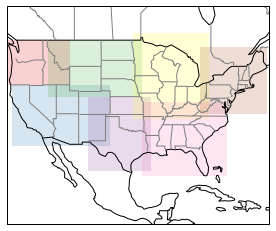

In [87]:

ax = plt.axes(projection=ccrs.Mercator())
#ax.set_extent([-125, -67, 20, 50])
ax.set_global()
ax.set_extent([-125, -66.5, 15, 50], ccrs.Geodetic())

# Put a background image on for nice sea rendering.
#ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

#ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(states_provinces, edgecolor='gray')

x=[-125,-111,-125,-111,-125]
y=[42,42,49,49,42]
#ax.plot(x, y, marker='o', transform=ccrs.LambertConformal())
#ax.fill(x, y, color='coral',  transform=ccrs.LambertConformal(),alpha=0.4)
i=-1
for region in NCA4regions.keys():
        i+=1
        w=float(np.diff(NCA4regions[region]["longitude"]))
        h=float(np.diff(NCA4regions[region]["latitude"]))
        xy=[min(NCA4regions[region]["longitude"]),min(NCA4regions[region]["latitude"])]
        ax.add_patch(mpatches.Rectangle(xy=xy, width=w, height=h,
                                        facecolor=cm.Set1(i/7.),
                                        alpha=0.2,
                                        transform=ccrs.PlateCarree())
                     )
#ax.plot(x,y,transform=ccrs.Mercator())

# Add a text annotation for the license information to the
# the bottom right corner.
# text = AnchoredText(r'$\mathcircled{{c}}$ {}; license: {}'
#                     ''.format(SOURCE, LICENSE),
#                     loc=4, prop={'size': 12}, frameon=True)
# ax.add_artist(text)

#plt.show()

plt.savefig("regions.png")

In [97]:
def regrid_models(variable,experiment):

    #get the shape from CESM2


    model = "CESM2"

    rip="r1i1p1f1"
    allfiles=sorted(glob.glob("/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"+"/"+variable+"/"+model+"/*."+experiment+".*."+rip+".*"))

    f=cdms.open(allfiles[0])
    data=f(variable)
    #for model in get_ok_models("SW"):

    grid=data.getGrid()
    nyears=86 #historical runs begin in 2015-2100
    model_shape=(12*nyears,)+grid.shape

    f.close()

    models=get_ok_models("SW")
    nmodels=len(models)
    bigshape=(nmodels,)+model_shape


    allmodels=MV.zeros(bigshape)
    for modeli in range(nmodels):
        model=models[modeli]
        print(model)
        allfiles_rips=sorted(glob.glob("/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"+"/"+variable+"/"+model+"/*."+experiment+".*"))
        rips=sorted(np.unique([x.split(".")[3] for x in allfiles_rips]))
        if len(rips)>0:
            rip=rips[0]
        else:
            continue
        allfiles=sorted(glob.glob("/home/kdm2144/DROUGHT/DOWNLOADED_RAW/"+"/"+variable+"/"+model+"/*."+experiment+".*."+rip+".*"))
        if len(allfiles ) >= nyears:
            for i in range(nyears):
                f=cdms.open(allfiles[i])
                data=f(variable)
                data_regrid=data.regrid(grid,regridTool='regrid2')
                if i==0:
                    bigdata=data_regrid
                else:
                    bigdata=MV.concatenate((bigdata,data_regrid))
                f.close()
            allmodels[modeli]=bigdata
        else:
            allmodels[modeli]=1.e20
    allmodels=MV.masked_where(np.abs(allmodels)>1.e10,allmodels)
    modax=cmip5.make_model_axis(models)
    tax=cdms.createAxis(np.arange(12*86))
    tax.units="months since 2015-1-1"
    tax.designateTime()
    tax.id='time'
    allmodels.setAxis(0,modax)
    allmodels.setAxis(1,tax)
    cdutil.setTimeBoundsMonthly(allmodels)
    allmodels.setAxis(2,data_regrid.getLatitude())
    allmodels.setAxis(3,data_regrid.getLongitude())    
    allmodels.name=variable
    allmodels.id=variable
    return allmodels


ACCESS-CM2
ACCESS-ESM1-5
CESM2
CESM2-WACCM
CanESM5
EC-Earth3
EC-Earth3-Veg
FGOALS-g3
HadGEM3-GC31-LL
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0


In [98]:
fw=cdms.open("/home/kdm2144/DROUGHT/Maps/"+variable+"."+experiment+".MMA.2015_2100.nc","w")
fw.write(allmodels)
fw.close()

In [100]:
mma=MV.average(allmodels,axis=0)

(1032, 192, 288)

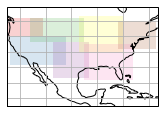

In [86]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import cartopy.crs as ccrs

desired_projections = [ccrs.PlateCarree()]
for plot_num, desired_proj in enumerate(desired_projections):

    ax = plt.subplot(2, 1, plot_num + 1, projection=desired_proj)

  
    ax.set_global()
    ax.set_extent([-125, -66.5, 15, 50], ccrs.Geodetic())
    i=-1
    for region in NCA4regions.keys():
        i+=1
        w=float(np.diff(NCA4regions[region]["longitude"]))
        h=float(np.diff(NCA4regions[region]["latitude"]))
        xy=[min(NCA4regions[region]["longitude"]),min(NCA4regions[region]["latitude"])]
        ax.add_patch(mpatches.Rectangle(xy=xy, width=w, height=h,
                                        facecolor=cm.Set1(i/7.),
                                        alpha=0.2,
                                        transform=ccrs.PlateCarree())
                     )

    
    ax.gridlines()
    ax.coastlines()

plt.show()


In [17]:
NCA4regions["NW"]

{'longitude': (-125, -111), 'latitude': (42, 49)}

In [82]:
region="NW"
w=float(np.diff(NCA4regions[region]["longitude"]))
h=float(np.diff(NCA4regions[region]["latitude"]))
xy=[min(NCA4regions[region]["longitude"]),min(NCA4regions[region]["latitude"])]

14.0